In [ ]:
!git clone https://github.com/Im-JihyunKim/2024_LG_ES_SSL.git  # colab 사용 시

In [ ]:
# Colab 사용 시 실행
# Local PC로 실습하는 경우에는 실행 X, 단 작업경로를 2024_LG_ES_RNN으로 맞춰주기
%cd /content/2024_LG_ES_SSL

In [1]:
# !pip install IPython
from IPython.display import Image

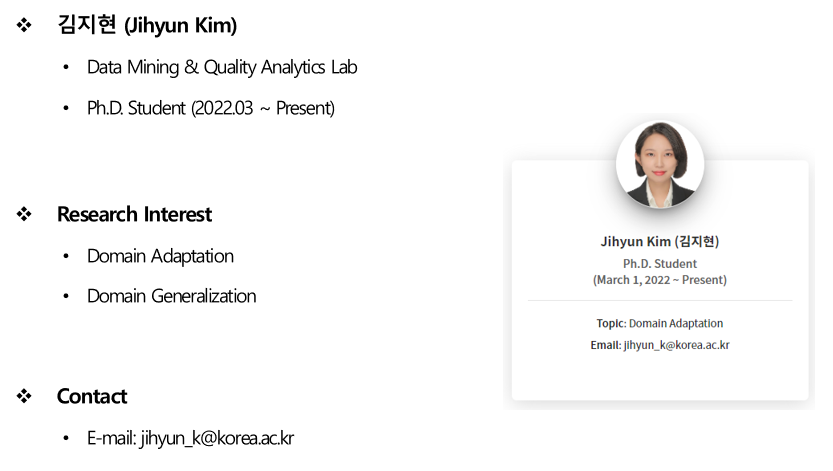

In [ ]:
Image('./images/jihyun.PNG')

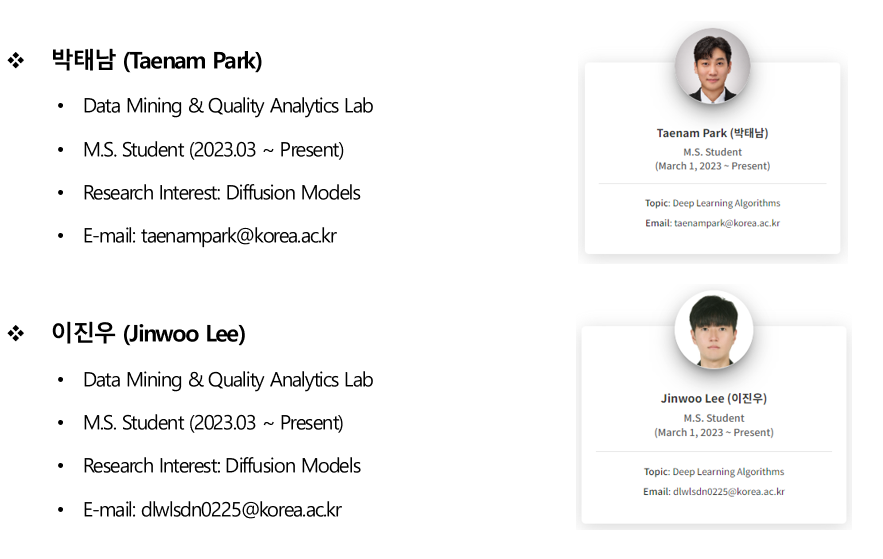

In [2]:
Image('./images/park_lee.PNG')

------

## Task: Self-supervised Learning - Information Maximization
### Barlow Twins

- 기존의 Contrastive Learning 방법론의 한계를 극복하고자 하였음
  1. 굉장히 큰 batch size를 요구하여 대용량 컴퓨터 자원을 필요로 함
  2. 어떤 데이터 증강 기법(augmentation)을 적용하는가에 따라 성능 편차가 존재
  3. 적절한 negative pair를 선정하거나 정의하기 어려움
- BYOL처럼 두 개의 모델을 이용하지도 않음
- __2개의 augmentation에 대한 representation 값을 유사하게 만드는 학습 방식__
  - 동일한 이미지에서 나온 서로 다른 이미지(view)는, 같은 의미를 담고 있으니 임베딩 벡터 값 간 교차 상관 계수(Cross-correlation)에서 대각 성분이 1이 되어야 함

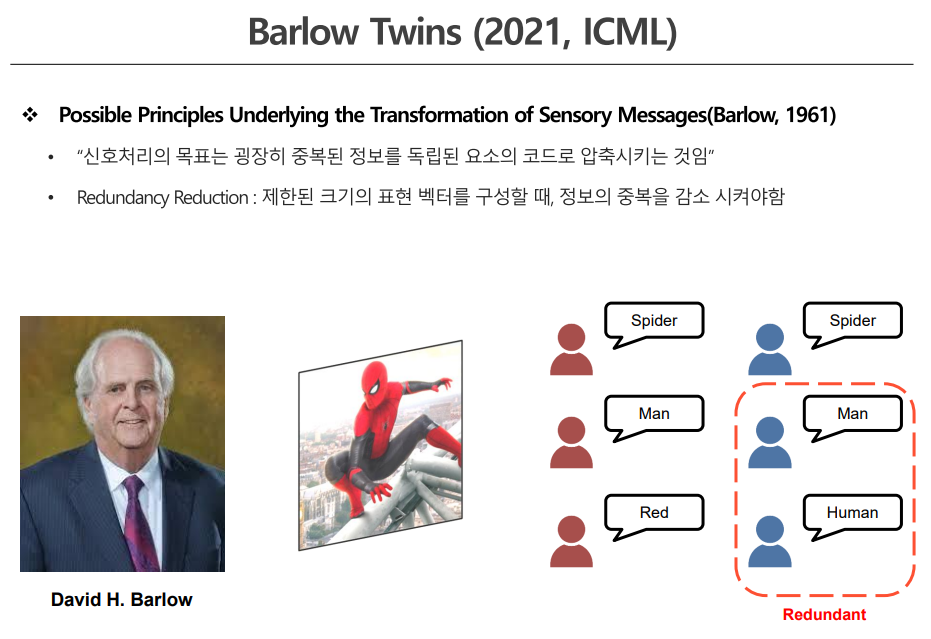

In [2]:
Image('./images/bt_intro.PNG')

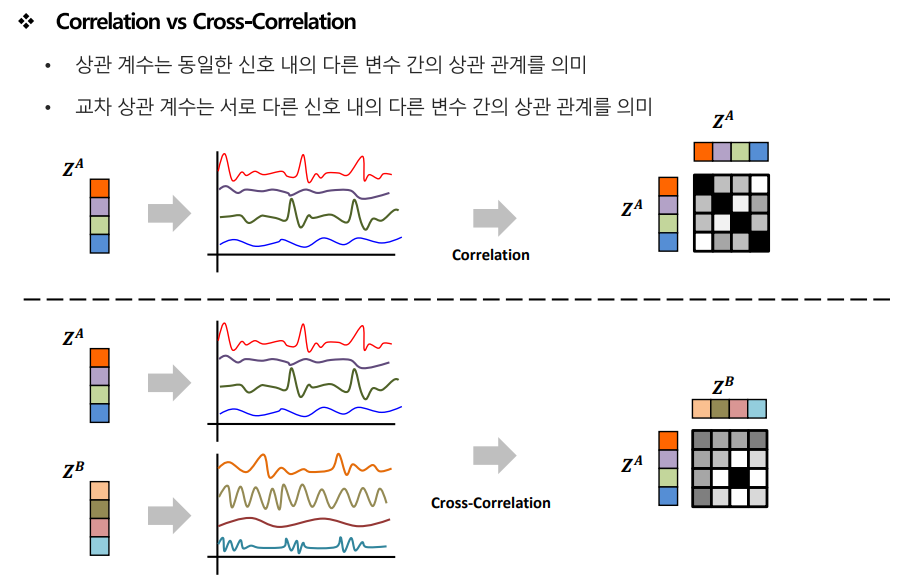

In [3]:
Image('./images/BT0.PNG')

## 1. 필요 라이브러리 호출

In [1]:
import os, random, time
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn 
import torchvision.models as models 
from torch.utils.data import Dataset, DataLoader, Subset 
from torchvision.transforms import transforms
from torchvision import transforms, datasets

import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

<Figure size 640x480 with 0 Axes>

## 2. Dataset 및 Dataloader 정의

### 실습 데이터셋: CIFAR10
- 32x32의 RGB 이미지로 구성된 데이터셋
- 10개의 class를 분류하는 image classification task에 주로 활용

In [2]:
class CIFAR10Dataset(Dataset):
    def __init__(self, configs:dict, aug_generator:object):
        self.configs = configs
        self.data_dir = configs['data_dir']
        self.aug_generator = aug_generator

        # 저장 경로 폴더가 없는 경우 만들어주어야 함
        os.makedirs(self.data_dir, exist_ok=True)

    """For SimCLR : SimCLR 사전학습 시 사용되는 데이터셋"""
    def get_pretrain_dataset(self, n_views: int=2):
        pretrain_dataset = datasets.CIFAR10(self.data_dir, 
                                            train=True,  # train 여부
                                            transform=self.aug_generator(   # 사전에 정의한 augmented images generator 기반으로 transform 수행
                                                    base_transform=self.get_transform(),  # 사전에 정의한 이미지 변형 방법 적용
                                                    n_views=n_views),  # view는 하나의 동일한 이미지를 다른 시각으로 본다는 의미로, number of views 만큼 augmentation 수행
                                            download=True)
        return pretrain_dataset
    
    """For Downstream task : Downstream 지도학습에 사용되는 데이터"""
    def get_dataset(self, mode: str='train'):
        downstream_dataset = datasets.CIFAR10(self.data_dir,
                                             train=False,   # train 여부
                                             transform=transforms.Compose([
                                                        transforms.ToTensor(),    # 이미지를 tensor 타입으로 바꾸어줌
                                                        transforms.Normalize(      # 이미지 데이터 내의 값을 정규화 (역전파 단계에서 gradient 계산 시 데이터마다 유사한 범위의 값을 가지도록 하기 위함)
                                                                mean=(0.4914, 0.4822, 0.4465),
                                                                std=(0.2023, 0.1994, 0.2010))
                                                                ]),
                                             download=True)
        
        train_idx, test_idx = train_test_split(list(range(len(downstream_dataset))), 
                                               test_size=0.2,
                                               random_state=self.configs['seed'])

        if mode == 'train':
            train_dataset = Subset(downstream_dataset, train_idx)  # 8,000개
            return train_dataset
        
        elif mode == 'test':
            test_dataset = Subset(downstream_dataset, test_idx)    # 2,000개
            return test_dataset
        
        else:
            raise NotImplementedError("'mode' should be one of ['train' or 'test']")
        
    @staticmethod  # 해당 클래스에서만 사용되는 메소드
    def get_transform(s:float=.5):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper! (BYOL은 SimCLR과 동일한 데이터 증강기법을 적용)
        - SImCLR에서는 augmentation에 대해서 'random crop and resize', 'color distortion', 'blur'가 결합된 augmentation이 좋은 성능을 도출한다고 설명
        """
        # 이미지 데이터 내의 값을 정규화
        ## gradient 역전파 과정에서 중요 (큰 값은 activation function 출력 값을 포화 영역에 다다르게 함 -> 미분 값이 작아짐 -> 기울기 소실)
        ## 작은 범위의 값으로 학습 안전성 확보
        ## 더불어 RGB 채널 중 특정 채널에 가중이 크게 치우치는 것을 방지 (스케일 차이로 인하여) (모든 색상 정보를 균등하게 고려)

        # normalized = (original - mean) / std.   # Standardization
        # CIFAR-10에 특화된 normalize!!
        normalize = transforms.Normalize( 
            mean=(0.4914, 0.4822, 0.4465),  # R, G, B 채널 평균 값
            std=(0.2023, 0.1994, 0.2010)    # R, G, B 채널의 표준편차
        )

        # s is the strength of color distortion (0.5 for CIFAR10 by default)
        color_jitter = transforms.ColorJitter(0.8*s, 
                                              0.8*s,
                                              0.8*s,
                                              0.2*s)
        
        # See Section B.9 of SimCLR: https://arxiv.org/abs/2002.05709
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=32),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),  # 이미지 데이터 텐서화
            normalize,              # 앞서 정의한 이미지 정규화 수행
        ])

        return data_transforms

In [3]:
"""사전에 정의한 transform 방식을 기반으로 증강된 이미지를 반환해주는 class"""
class aug_generator(object):
    """
    Take 2 random crops of one image as the query and key.
    """
    def __init__(self, base_transform, n_views: int=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):  # aug_generator 클래스 호출 시 수행되는 함수
        return [self.base_transform(x) for i in range(self.n_views)]  # n_views 만큼 base_transform(get_transform 메소드에서 정의된 증강기법)을 수행하라

--------

## 3. Barlow Twins 모델 정의

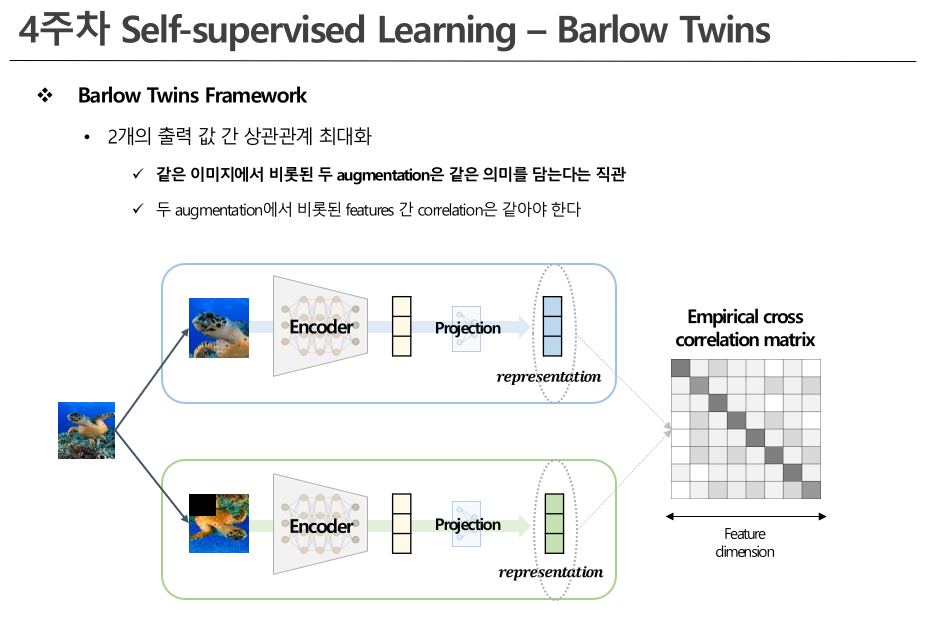

In [7]:
Image('./images/BT.PNG')

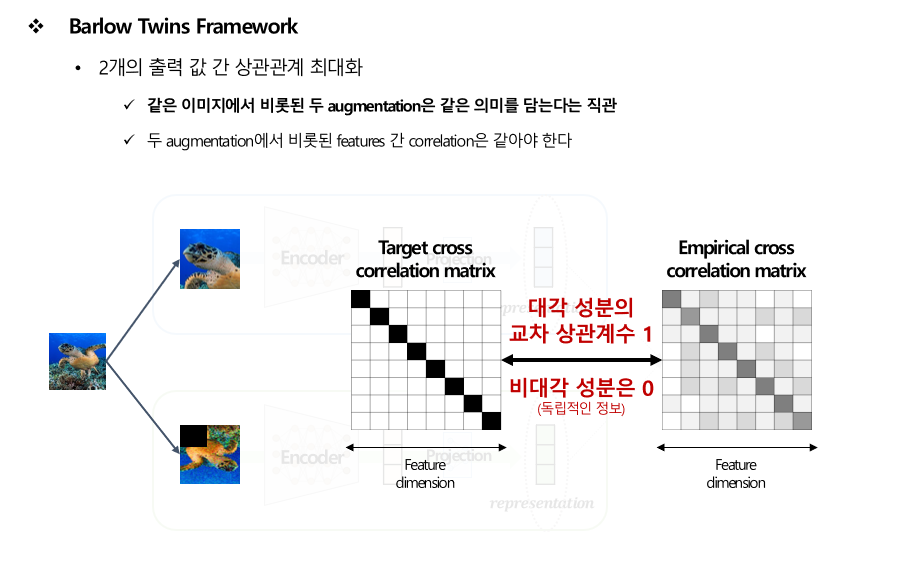

In [9]:
Image('./images/BT2.PNG')

In [45]:
class BarlowTwins(nn.Module):
    def __init__(self, configs):
        super(BarlowTwins, self).__init__()
        self.configs = configs
        self.device = configs['device']

        self.backbone = configs['backbone']
        self.hidden_dim = configs['hidden_dim']
        self.projection_dim = configs['projection_dim']

        self.lam = configs['lam']

        ## Base encoder 선정
        # load model from torchvision.models without pretrained weights.
        resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),   
            'resnet50': models.resnet50(pretrained=False)
        }
        self.encoder = resnet_dict[self.backbone]

        # Customize for CIFAR10. Replace conv 7z7 with conv 3x3, and remove first max pooling
        self.encoder.conv1 = nn.Conv2d(in_channels=3,
                                       out_channels=64, 
                                       kernel_size=3, 
                                       stride=1, 
                                       padding=1, 
                                       bias=False)
        
        self.encoder.maxpool = nn.Identity()  # 입력과 동일한 tensor를 출력으로 내보내주는 layer

        """get feature dim from in_features in fc-layer for resnet18 in torchvision"""
        feature_dim = self.encoder.fc.in_features  # resnet18.fc.in_features=256
        self.encoder.fc = nn.Identity()  # remove final fully connected layer

        # Add MLP projection
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_dim, self.projection_dim),
            nn.BatchNorm1d(self.projection_dim),
        )

        # Add MLP predictor
        self.predictor = nn.Sequential(
            nn.Linear(self.projection_dim, self.projection_dim//2), 
            nn.BatchNorm1d(self.projection_dim//2),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim//2, self.projection_dim)
        )

    def forward(self, img1, img2):
        loss = self.barlow_loss(img1, img2)
        return loss
    
    def encode(self, img):
        H = self.encoder(img)
        Z = self.projector(H)
        return Z
    
    def barlow_loss(self, 
                  batch_view_1: torch.FloatTensor, 
                  batch_view_2: torch.FloatTensor):
        
        Z1 = self.encode(batch_view_1)
        Z2 = self.encode(batch_view_2)

        # empirical cross-correlation matrix
        cross_correlation_mat = Z1.T @ Z2 # torch.mm(Z1.T, Z2)
        cross_correlation_mat.div_(Z1.size(0))  # divide by batch size
        
        on_diag = torch.diagonal(cross_correlation_mat).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal(cross_correlation_mat).pow_(2).sum()

        loss = on_diag + self.lam * off_diag

        return loss.sum()
    
    @staticmethod
    def off_diagonal(cross_correlation_matrix):
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = cross_correlation_matrix.shape
        assert n == m
        return cross_correlation_matrix.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [8]:
data_configs = {'data_dir':'./data/'}
Cifar10 = CIFAR10Dataset(data_configs, aug_generator)
Cifar10_aug_dataset = Cifar10.get_pretrain_dataset()

img_list, labels = next(iter(DataLoader(Cifar10_aug_dataset, batch_size=3)))  # labeels도 반환
img1, img2 = img_list[0], img_list[1]

model_configs = {'device':'cuda',
                 'backbone':'resnet18',
                 'hidden_dim': 512,
                 'projection_dim':128,
                 'lam':5e-3}
barlow = BarlowTwins(model_configs)

H1 = barlow.encoder(img1)
Z1 = barlow.projector(H1)

H2 = barlow.encoder(img2)
Z2 = barlow.projector(H2)

Files already downloaded and verified


In [18]:
cross_corr_mat = (Z1.T @ Z2) / Z1.size(0); cross_corr_mat

tensor([[-0.2780,  0.6666,  0.2116,  ..., -0.9416,  0.7191,  0.0112],
        [-0.4262,  0.5405,  0.3633,  ..., -0.9829,  0.8196, -0.1469],
        [-0.3135, -0.9710,  0.3778,  ...,  0.5868, -0.2011, -0.5744],
        ...,
        [ 0.6044, -0.3546, -0.5485,  ...,  0.9996, -0.9202,  0.3486],
        [ 0.9903,  0.4091, -0.9786,  ...,  0.6903, -0.9262,  0.9086],
        [-0.9839, -0.6725,  0.9938,  ..., -0.4312,  0.7639, -0.9934]],
       grad_fn=<DivBackward0>)

In [26]:
# torch.diagonal() -> 대각성분 요소만 추출
torch.diagonal(cross_corr_mat)

tensor([-0.2780,  0.5405,  0.3778, -0.9276, -0.4735,  0.4563, -0.1673,  0.9923,
         0.9533, -0.9973,  0.9601,  0.4539,  0.7302,  0.2144, -0.4748, -0.8381,
         0.9569,  0.8071,  0.9723,  0.1973,  0.9879, -0.9997, -0.0527, -0.5035,
         0.9899,  0.7954, -0.9033, -0.7951,  0.9098,  0.7423, -0.8486, -0.0214,
         0.7886,  0.8109,  0.9616,  0.2833,  0.9995, -0.1034,  0.9911,  0.9510,
         0.7331,  0.8236,  0.7740,  0.7325,  0.0704,  0.5910, -0.4500, -0.7866,
        -0.9504,  0.5306, -0.6955,  0.9570, -0.3112,  0.9150,  0.8641,  0.3206,
         0.5672,  0.9999,  0.9992, -0.9866,  0.9145, -0.1390,  0.6917, -0.9953,
        -0.9945,  0.2698, -0.5251,  0.4273, -0.2314, -0.9786,  0.6095,  0.7429,
         0.2878, -0.5543,  0.8900, -0.4304,  0.3872,  0.5789,  0.3293,  0.9945,
         0.9996,  0.6022,  0.6961,  0.9727,  0.9383, -0.9368, -0.3664,  0.7670,
        -0.4402, -0.0526, -0.7036,  0.9132,  0.6785,  0.4495, -0.8753, -0.9850,
        -0.9891,  0.8683, -0.9984, -0.79

In [27]:
# 1. 대각성분은 z1과 z2 간 같은 차원의 특징들에 대한 상관관계를 나타냄
## 대각 요소가 1에 가까울 수록 네트워크가 aug에 상관없이 강건한 특징을 학습했다고 보여짐 (다른 aug더라도 특징이 같다는 의미)
on_diag = torch.diagonal(cross_corr_mat).add(-1).pow(2).sum(); on_diag
## 따라서 1을 빼주고 (= -1을 더해주고)
## 제곱을 통해서 양수와 음수 편차를 동일하게 취급

tensor(156.1913, grad_fn=<SumBackward0>)

In [36]:
def off_diagonal(cross_correlation_matrix):
    # return a flattened view of the off-diagonal elements of a square matrix
    n, m = cross_correlation_matrix.shape
    assert n == m
    return cross_correlation_matrix.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

In [39]:
n, m = cross_corr_mat.shape
print(n, m)

flatten_matrix = cross_corr_mat.flatten()[:-1]  # 행렬을 1차원으로 펼친 후 마지막 요소 제외
matrix = flatten_matrix.view(n-1, n+1)   # 펼쳐진 tensor를 (n-1) x (n+1) 크기의 2차원 행렬로 재구성
matrix = matrix[:, 1:]   # 행렬에서 첫 번째 열을 제외한 나머지를 선택
matrix.flatten()   # 최종 결과물을 다시 1차원으로 펼침

128 128


tensor([ 0.6666,  0.2116, -0.6209,  ..., -0.7514, -0.4312,  0.7639],
       grad_fn=<UnsafeViewBackward0>)

In [40]:
x = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])

# 1. 펼치고 마지막 요소 제외
## 우하단 요소를 제거해서, 다음 단계 행렬로 재구성할 때 정확한 형태를 만듦
flattened = x.flatten()[:-1]
print("Flattened:", flattened)

# 2. (n-1) x (n+1)로 재구성
## 비대각 요소를 효율적으로 추출하기 위해서 (nxn -> n^2), (n^2-1 -> n-1 x n+1)
## 위처럼 바꾸면 각 행에 원래 행렬의 한 행 (자기 자신 제외)과 다음 행의 일부가 포함됨
reshaped = flattened.view(2, 4)
print("Reshaped:\n", reshaped)

# 3. 첫 번째 열 제외
## 재구성된 행렬의 첫 번째 열은 원래 행렬의 대각 요소들임. 이를 제외해서 순수 비대각 요소만 남김
result = reshaped[:, 1:].flatten()
print("Final result:", result)

Flattened: tensor([1, 2, 3, 4, 5, 6, 7, 8])
Reshaped:
 tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])
Final result: tensor([2, 3, 4, 6, 7, 8])


In [41]:
off_diag = off_diagonal(cross_corr_mat); off_diag

tensor([ 0.6666,  0.2116, -0.6209,  ..., -0.7514, -0.4312,  0.7639],
       grad_fn=<UnsafeViewBackward0>)

In [42]:
off_diag.pow(2).sum()  # (양수든 음수든) 큰 상관관계에 높은 패너티를 부여해서 줄일 것 (0으로 만들 것)

tensor(8144.4141, grad_fn=<SumBackward0>)

In [43]:
lam = 5e-3   # coefficient
loss = on_diag + lam * off_diag; loss

tensor([156.1946, 156.1924, 156.1882,  ..., 156.1876, 156.1892, 156.1951],
       grad_fn=<AddBackward0>)

In [44]:
loss.sum()

tensor(2539046.2500, grad_fn=<SumBackward0>)

-------

## 4. 모델 학습

### Optimizer 정의

In [46]:
def get_optimizer(configs, model):
    if configs['optimizer'] == "sgd":
        optimizer = torch.optim.SGD(params=model.parameters(), lr=configs['lr'],
                              momentum=0.9, weight_decay=configs['weight_decay'])

    elif configs['optimizer'] == "adam":
        optimizer = torch.optim.Adam(params=model.parameters(), lr=configs['lr'], 
                                    weight_decay=configs['weight_decay'])
    else:
        print("Invalid optimizer name, it should be one of ['sgd', 'adam']. Exiting...")
        exit()

    return optimizer

### 모델 학습 추세 시각화 함수 정의

In [47]:
def visualize_model_training(epoch_history):
    # Loss 추세 시각화
    sns.lineplot(x=range(1, len(epoch_history['loss'])+1), y=epoch_history['loss'], label="Pretrain Loss")
    plt.title("Pretrain Loss Graph")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

### 사전학습 과정 함수화

In [48]:
def pretrain(device, model, pretrain_loader, optimizer):
    model.train()
    num_iterations = len(pretrain_loader)
    pretrain_history = {'loss': torch.zeros(num_iterations)}

    for i, (img, _) in enumerate(pretrain_loader):
        """사전학습 단계에서는 X 데이터만 batch로 받을 수 있음! (y는 없음)"""

        # 증강된 두 데이터 불러오기
        img_aug_1, img_aug_2 = img[0].to(device), img[1].to(device)

        # loss 계산!
        loss = model(img_aug_1, img_aug_2)

        loss.backward()
        optimizer.step()       # optimizer를 이용한 파라미터 업데이트
        optimizer.zero_grad()  # Optimizer Gradient 초기화

        pretrain_history['loss'][i] = loss.item()

    pretrain_history = {k: v.mean().item() for k, v in pretrain_history.items()}

    return pretrain_history

### `main()` 함수를 통한 학습 수행

In [49]:
# 똑같은 결과를 얻기 위한 시드 고정
def set_seed(seed:int=0):
    torch.manual_seed(seed) # torch cpu seed 고정
    torch.cuda.manual_seed(seed) # torch gpu seed 고정
    torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(seed) # numpy seed 고정
    random.seed(seed)    # python seed 고정
    os.environ['PYTHONHASHSEED'] = str(seed)

In [50]:
def main(configs):
    """Step 1: 학습 전 세팅: device, seed, configs 확인, data 정의, model 정의, loss function 및 optimizer 정의"""
    device = configs['device']  # Device 정의
    set_seed(configs['seed'])   # seed 정의

    # 우리가 설정한 하이퍼파라미터가 무엇인지 프린트하여 확인
    print(f"Configurations: \n {configs}")

    # 학습 결과를 저장할 경로 설정
    save_dir = os.path.join(configs['save_dir'], 'Pretrain')
    # make checkpoint directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)

    ### 데이터셋 정의
    dataset = CIFAR10Dataset(configs, aug_generator)
    pretrain_dataset = dataset.get_pretrain_dataset(n_views=2)
    pretrain_loader = DataLoader(
        dataset=pretrain_dataset,
        batch_size=configs['batch_size'],
        shuffle=True,
        num_workers=0,
        drop_last=False
    )

    ### Model Architecture 정의
    model = BarlowTwins(configs).to(device)

    ### optimizer
    optimizer = get_optimizer(configs, model)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer,
        T_max=configs['num_epochs'],
        eta_min=configs['lr']*1e-2
    )

    # Pretraining
    epoch_history = {'loss': []}
    
    start = time.time()

    """Step 2: 사전학습 시작"""
    for epoch in range(1, configs['num_epochs']+1):
        print('-'*15, f'Epoch: {epoch}', '-'*15)

        pretrain_result = pretrain(device, model, pretrain_loader, optimizer)
        lr_scheduler.step()

        print(f"Loss: {pretrain_result['loss']:.2f}")

        """Step 3: 학습 중 도출된 loss 및 acc 값들 저장"""
        epoch_history['loss'].append(pretrain_result['loss'])

    """last epoch에서 checkpoint 저장"""
    torch.save(model.encoder.state_dict(), os.path.join(save_dir, 'pretrained_BarlowTwins.pt'))

    ## 학습 추세 시각화
    if configs['visualize']:
        visualize_model_training(epoch_history)

    # 사전학습에 소요된 시간 계산 후 출력
    end_sec = time.time() - start
    end_min = end_sec / 60
    print(f"Total Training Time: {end_min:.2f} minutes")

    return model

Configurations: 
 {'device': device(type='cuda'), 'seed': 0, 'data_dir': './data/', 'save_dir': './results/BarlowTwins', 'batch_size': 256, 'backbone': 'resnet18', 'hidden_dim': 512, 'projection_dim': 128, 'lam': 0.005, 'num_epochs': 10, 'optimizer': 'sgd', 'lr': 0.05, 'weight_decay': 0.0005, 'visualize': True}
Files already downloaded and verified
--------------- Epoch: 1 ---------------
Loss: 35.34
--------------- Epoch: 2 ---------------
Loss: 20.93
--------------- Epoch: 3 ---------------
Loss: 17.93
--------------- Epoch: 4 ---------------
Loss: 15.14
--------------- Epoch: 5 ---------------
Loss: 13.08
--------------- Epoch: 6 ---------------
Loss: 11.46
--------------- Epoch: 7 ---------------
Loss: 10.63
--------------- Epoch: 8 ---------------
Loss: 10.21
--------------- Epoch: 9 ---------------
Loss: 9.79
--------------- Epoch: 10 ---------------
Loss: 9.61


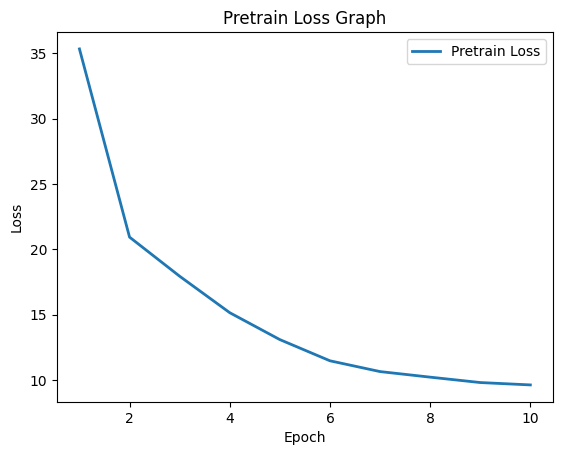

Total Training Time: 18.84 minutes


In [51]:
if __name__ == '__main__':
    configs={
        # basic setting
        'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
        'seed':0,

        # dataset hyperparameters
        'data_dir':'./data/',
        'save_dir':'./results/BarlowTwins',
        'batch_size':256,

        # model hyperparameters
        'backbone':'resnet18',
        'hidden_dim':512,
        'projection_dim':128,
        'lam':5e-3,

        # training hyperparameters
        'num_epochs':10,
        'optimizer':'sgd',
        'lr':5e-2,
        'weight_decay':5e-4,
        'visualize':True
    }
    
    pretrained_model = main(configs)

----------------------------------

## 5. Downstream Task

### 모델 성능 평가 지표 정의

In [52]:
def accuracy(output: torch.FloatTensor,
             target: torch.LongTensor,
             topk: tuple=(1, )):
    
    ### max_k기준 correct 여부 판별
    with torch.no_grad():
        max_k = max(topk) 
        batch_size = target.size(0) 
        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)) ### eq: 동일여부 판별

        ### 확인하고 싶은 topk 지표들을 모두 산출 
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res

In [53]:
""" 1. 미세조정 (Downstream Task) 학습 알고리즘 정의 """
class Downstream(object):

    ### 학습에 필요한 값들 초기화
    def __init__(self, device, encoder, classifier, optimizer, **kwargs):
        self.device = device
        self.encoder = encoder.to(device)   
        self.classifier = classifier.to(device)
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss().to(device)
        self.__dict__.update(kwargs)

    ### Downstream Task 학습 알고리즘
    def train_test(self, train_loader, test_loader):

        ### Train 모드 
        for epoch in range(self.epochs):
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 사전학습된 Encoder에 데이터 통과
                if self.downstream: ### Encoder Weight(사전학습된)를 학습하지 않음
                    with torch.no_grad():
                        logits = self.encoder(images)
                        logits = logits.squeeze()
                else: ### Encoder Weight를 함께 학습
                    logits = self.encoder(images)
                    logits = logits.squeeze()

                ### Classifier에 통과
                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)

                ### 모델 학습
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                ### Iteration 단위(Batch) 평가 지표 산출
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)

            ### Test 모드 
            top1_test_acc, top5_test_acc = 0, 0
            for i, (images, targets) in enumerate(test_loader):

                ### 데이터를 Batch 단위로 불러오기
                images = images.to(self.device)
                targets = targets.to(self.device)

                ### 데이터를 모델(Encoder + Classifier)에 통과
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)

                ### Iteration 단위(Batch) 평가 지표 산출
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]

            ### Epoch 단위(전체 학습데이터) 평가 지표 산출
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)
            
            ### Log
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {round(train_loss.item(), 4)} \n'
                  f'Top1 Train Accuracy: {round(top1_train_acc.item(), 2)} \n'
                  f'Top1 Test Accuracy: {round(top1_test_acc.item(), 2)} \n'
                  f'Top5 Test Accuracy: {round(top5_test_acc.item(), 2)} \n')
        
        return self.encoder, self.classifier

## 사전학습 된 Encoder를 이용하여 Downstream Task 수행
- Transfer Learning(전이 학습)의 개념
- 사전학습 된 인코더를 활용하여 Supervised Learning 수행

In [54]:
""" 2. 미세조정 (Downstream Task) 수행 - Encoder Freeze (O) """
def main(configs: dict):
    set_seed(configs['seed'])

    ### Train 및 Test 데이터셋 정의 
    Cifar10_dataset = CIFAR10Dataset(configs, aug_generator)
    
    train_dataset = Cifar10_dataset.get_dataset(mode='train')
    test_dataset = Cifar10_dataset.get_dataset(mode='test')
    
    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=configs['batch_size'],
            shuffle=True,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=configs['batch_size'],
            shuffle=False,
            num_workers=configs['num_worker'],
            drop_last=False)
    
    ### Model Architecture 정의
    encoder = BarlowTwins(configs).encoder
    ### 사전학습된 Weight 불러오기
    encoder.load_state_dict(torch.load(os.path.join(configs['save_dir'], 'pretrained_BarlowTwins.pt')))
    print("All keys matched successfully")

    classifier = nn.Linear(512, configs['num_class'])

    ### Optimizer 정의
    optimizer = torch.optim.SGD(
        params=classifier.parameters(), 
        lr=configs['learning_rate'], 
        momentum=0.9,
        weight_decay=configs['weight_decay'])
    
    ### Downstream Task 학습 알고리즘 정의
    downstream = Downstream(
        device = configs['device'],
        encoder=encoder,
        classifier=classifier,
        optimizer=optimizer,
        epochs=configs['epochs'],
        downstream = configs['downstream'])
    
    ### Downstream Task 학습 수행
    supervised_encoder, supervised_classifier = downstream.train_test(train_loader=train_loader,
                                                                        test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier

### Main
if __name__ == '__main__':  
    configs = {'seed':0,
               'device':torch.device("cuda" if torch.cuda.is_available() else 'cpu'),
               'data_dir': './data/', 
               'save_dir':'./results/BarlowTwins/Pretrain',
               'lam':5e-3,
               'downstream': True, 'batch_size': 256, 'epochs': 15, 
               'learning_rate': 5e-3, 'weight_decay':1e-6,
               'backbone': 'resnet18', 'hidden_dim': 1024, 'projection_dim': 1024,
               'num_class': 10, 'num_worker': 0}
    supervised_model = main(configs)

Files already downloaded and verified
Files already downloaded and verified
All keys matched successfully
Epoch: 1 
Loss: 2.1012 
Top1 Train Accuracy: 22.39 
Top1 Test Accuracy: 29.84 
Top5 Test Accuracy: 79.7 

Epoch: 2 
Loss: 1.9275 
Top1 Train Accuracy: 29.48 
Top1 Test Accuracy: 31.0 
Top5 Test Accuracy: 81.68 

Epoch: 3 
Loss: 1.9157 
Top1 Train Accuracy: 29.77 
Top1 Test Accuracy: 30.4 
Top5 Test Accuracy: 82.28 

Epoch: 4 
Loss: 1.9067 
Top1 Train Accuracy: 30.33 
Top1 Test Accuracy: 32.22 
Top5 Test Accuracy: 82.63 

Epoch: 5 
Loss: 1.8787 
Top1 Train Accuracy: 31.98 
Top1 Test Accuracy: 32.9 
Top5 Test Accuracy: 81.53 

Epoch: 6 
Loss: 1.8768 
Top1 Train Accuracy: 31.37 
Top1 Test Accuracy: 33.85 
Top5 Test Accuracy: 82.21 

Epoch: 7 
Loss: 1.8633 
Top1 Train Accuracy: 31.85 
Top1 Test Accuracy: 32.43 
Top5 Test Accuracy: 82.79 

Epoch: 8 
Loss: 1.8518 
Top1 Train Accuracy: 32.9 
Top1 Test Accuracy: 34.06 
Top5 Test Accuracy: 84.4 

Epoch: 9 
Loss: 1.8478 
Top1 Train Accuracy:

## **실험결과 비교**

|   | Supervised Learning | SimCLR Downstream | BYOL Downstream | SimSiam Downstream | Barlow Twins |
|---| ------------------- | ----------- | --------- | --------- | --------- | 
|Top 1 Test ACC| 26.77 | 39.11 | 28.81 | 27.00 | 33.49 |
|Top 5 Test ACC| 77.13 | 88.50 | 79.48 | 80.04 | 84.27 |